# **Reinforcement Learning: Taller 4**
## Estudiantes: Juan Pablo Reyes Fajardo y Santiago Rodríguez Ávila 

In [45]:
!pip -q install tqdm
import gym
import random
import numpy as np
import itertools
import operator
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

# Funciones auxiliares

In [7]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [8]:
# Funcion Auxiliar para diccionarios
def key_max(d):
        return max(d.items(), key=operator.itemgetter(1))
def key_min(d):
        return min(d.items(), key=operator.itemgetter(1))

# MDP

In [9]:
env = gym.make('CartPole-v1')

# 1. RL Tabular

Política $\epsilon$ - Greedy 

(Útil más adelante)

In [138]:
def eps_greedy(Q_, state,epsilon=0.1):
    rand = np.random.uniform()
    if rand>epsilon:
        return key_max(Q_[state])[0],1-epsilon
    else:
        return random.choice(list(Q_[state])),epsilon

## Discretización

Inicialmente se realizan múltiples experimentos para determinar límites razonables para las variables a discretizar (aquellas cuyo espacio de observación es infinito)

In [11]:
velocidades_absolutas_maximas={"Lineal":[],"Angular":[]}

observation = env.reset()

abs_lineal=abs(observation[1])
abs_angular=abs(observation[3])

for _ in range(int(1e6)):
    
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated = env.step(action)
    
    if abs(observation[1])>abs_lineal:
        abs_lineal=abs(observation[1])
    if abs(observation[3])>abs_angular:
        abs_angular=abs(observation[3])

    if terminated or truncated:
        observation= env.reset()
        velocidades_absolutas_maximas["Lineal"].append(abs_lineal)
        velocidades_absolutas_maximas["Angular"].append(abs_angular)

env.close()

vel_lin_abs_max=np.mean(velocidades_absolutas_maximas["Lineal"])
vel_ang_abs_max=np.mean(velocidades_absolutas_maximas["Angular"])
print(f'Promedio de velocidad lineal absoluta máxima: \
      {vel_lin_abs_max} \
      \nPromedio de velocidad angular absoluta máxima: \
      {vel_ang_abs_max}')

Promedio de velocidad lineal absoluta máxima:       3.1324585240114797       
Promedio de velocidad angular absoluta máxima:       3.435788314235238


Discretización de estados:

In [12]:
# Límites del espacio de observación del MDP real
cart_high_var = env.observation_space.high
cart_low_var = env.observation_space.low

# Espacios de observación discretizados
observation_space_discrete_400=[np.linspace(cart_low_var[0], cart_high_var[0], num= 5),\
                            np.linspace(-vel_lin_abs_max, vel_lin_abs_max, num= 4),\
                            np.linspace(cart_low_var[2], cart_high_var[2], num = 5),\
                            np.linspace(-vel_ang_abs_max, vel_ang_abs_max, num= 4)]\

observation_space_discrete_4096=[np.linspace(cart_low_var[0], cart_high_var[0], num= 8),\
                            np.linspace(-vel_lin_abs_max, vel_lin_abs_max, num= 8),\
                            np.linspace(cart_low_var[2], cart_high_var[2], num = 8),\
                            np.linspace(-vel_ang_abs_max, vel_ang_abs_max, num= 8)]

# Uso de iteradores para obtener todos los estados a partir del espacio de obsevación discreto
states_400=list(itertools.product(*observation_space_discrete_400))
states_4096=list(itertools.product(*observation_space_discrete_4096))

def init_Q_400():
    Q_table={}
    for i in states_400:
        Q_table[i] = {0:0,1:0}
    return Q_table

def init_Q_4096():
    Q_table={}
    for i in states_4096:
        Q_table[i] = {0:0,1:0}
    return Q_table
         
def discretize_400(new_state):
    # car pos, car vel, pole angle, pole vel
    discretizacion=[0]*4
    for i in range(len(discretizacion)):
        dif = [(abs(x - new_state[i])) for x in observation_space_discrete_400[i]]
        discretizacion[i] = observation_space_discrete_400[i][dif.index(min(dif))]
        
    return tuple(discretizacion)

def discretize_4096(new_state):
    # car pos, car vel, pole angle, pole vel
    discretizacion=[0]*4
    for i in range(len(discretizacion)):
        dif = [(abs(x - new_state[i])) for x in observation_space_discrete_4096[i]]
        discretizacion[i] = observation_space_discrete_4096[i][dif.index(min(dif))]
        
    return tuple(discretizacion)

## Estimación de Q con Q-Learning 

### 400 Estados

In [135]:
def Q_Learning_400(gamma,alpha,epsilon):
    terminated=False
    observation = env.reset()
    observation=discretize_400(observation)
    G=0
    while True:
        #env.render(mode = "human")
        action,_=eps_greedy(Q,observation,0.1)
        
        observation_, reward, terminated, truncated = env.step(action)
        observation_=discretize_400(observation_)
        
        G+=reward
        
        Q_=key_max(Q[observation_])[1]

        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_
        if terminated:
            return G

In [48]:
Q=init_Q_400()
policy=dict.fromkeys(states_400, 0)
Gs=[]
epsilons=np.linspace(0.9,0.1,int(1e4))

for i in tqdm(range(len(epsilons))):
    Gs.append(Q_Learning_400(0.9,alpha,epsilons[i]))
print(f'Alpha: {alpha} Retorno: {np.mean(Gs)}')
    

env.close()

  0%|          | 0/10000 [00:00<?, ?it/s]


NameError: name 'alpha' is not defined

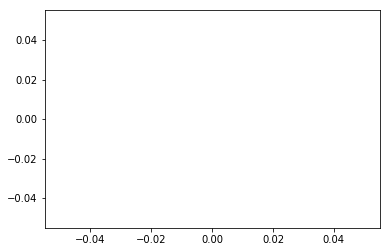

In [29]:
plt.plot(running_mean(Gs,100))

In [160]:
def Q_Learning_4096(gamma,alpha):
    terminated=False
    observation = env.reset()
    observation=discretize_4096(observation)
    G=0
    while True:
        
        action,_=eps_greedy(Q,observation,0.25)
        
        observation_, reward, terminated, truncated = env.step(action)
        observation_=discretize_4096(observation_)
        
        G+=reward
        
        Q_=key_max(Q[observation_])[1]

        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_
        if terminated:
            return G
        

In [161]:
Q=init_Q_4096()
policy=dict.fromkeys(states_4096, 0)
epsilons=np.linspace(0.9,0.01,int(1e8))
Gs=[]

for i in tqdm(range(len(epsilons))):
    Gs.append(Q_Learning_4096(0.95,0.1))
print(f' Retorno: {np.mean(Gs)}')

  8%|▊         | 7693933/100000000 [4:22:39<52:31:14, 488.20it/s] 


KeyboardInterrupt: 

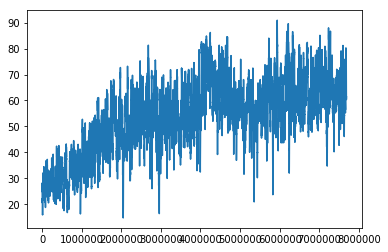

In [164]:
plt.plot(running_mean(Gs,10000))

In [79]:
for state_4096 in states_4096:
    policy[state_4096],_=eps_greedy(Q,tuple(state_4096),0)

In [1]:

rwds=[]
for _ in range(100):
    observation = env.reset()
    r=0
    while True:
        action = policy[discretize_4096(observation)]
        env.render(mode = "human")
        observation, reward, terminated, truncated = env.step(action)
        r+=reward

        if terminated or truncated:
            observation = env.reset()
            rwds.append(r)
            break
env.close()
print(np.mean(rwds))

NameError: name 'env' is not defined

In [8]:

ENV_NAME = 'CartPole-v1'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)

nb_actions = env.action_space.n

model = Sequential(
    [
        Flatten(input_shape=(1,) + env.observation_space.shape),
        Dense(16, activation="relu"),
        Dense(2, activation="linear"),
    ]
)


print(model.summary())

policy = EpsGreedyQPolicy()

memory = SequentialMemory(limit=50000, window_length=1)

dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)

dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

dqn.fit(env, nb_steps=100, visualize=True, verbose=2)

visualkeras.layered_view(model)

dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None
Training for 100 steps ...


ValueError: Error when checking input: expected flatten_1_input to have shape (1, 4) but got array with shape (1, 2)

In [1]:

!python --version
print('NumPy', np.__version__)
print('Tensorflow', tensorflow.__version__)

Python 3.9.13


NameError: name 'np' is not defined

In [ ]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory


from rl.callbacks import Callback

class EpisodeRewardCallback(Callback):
    def __init__(self):
        super(EpisodeRewardCallback, self).__init__()
        self.episode_rewards = []

    def on_episode_end(self, episode, logs):
        episode_reward = logs['episode_reward']
        self.episode_rewards.append(episode_reward)
        print(f"Episode {episode + 1} reward: {episode_reward}")

# Create an instance of the callback
episode_callback = EpisodeRewardCallback()

ENV_NAME = 'CartPole-v0'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
#np.random.seed(123)
#env.seed(123)
nb_actions = env.action_space.n

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(4))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=int(1e5), window_length=1)
policy = EpsGreedyQPolicy()

dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.

dqn.fit(env, nb_steps=int(1e5), visualize=True, verbose=2,callbacks=[episode_callback])

# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Training for 100000 steps ...
Episode 1 reward: 10.0
    10/100000: episode: 1, duration: 1.360s, episode steps: 10, steps per second: 7, epi

/opt/conda/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 2 reward: 9.0
    19/100000: episode: 2, duration: 1.201s, episode steps: 9, steps per second: 7, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.153 [-2.888, 1.809], loss: 0.500943, mean_absolute_error: 0.531230, mean_q: -0.009534


/opt/conda/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 3 reward: 10.0
    29/100000: episode: 3, duration: 0.740s, episode steps: 10, steps per second: 14, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.131 [-3.081, 2.001], loss: 0.484710, mean_absolute_error: 0.518994, mean_q: 0.002447


/opt/conda/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 4 reward: 8.0
    37/100000: episode: 4, duration: 0.609s, episode steps: 8, steps per second: 13, episode reward: 8.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.137 [-2.557, 1.609], loss: 0.471954, mean_absolute_error: 0.508764, mean_q: 0.014994
Episode 5 reward: 11.0
    48/100000: episode: 5, duration: 0.764s, episode steps: 11, steps per second: 14, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.909 [0.000, 1.000], mean observation: -0.134 [-2.818, 1.745], loss: 0.461572, mean_absolute_error: 0.496645, mean_q: 0.029505
Episode 6 reward: 9.0
    57/100000: episode: 6, duration: 0.625s, episode steps: 9, steps per second: 14, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.132 [-2.824, 1.790], loss: 0.451451, mean_absolute_error: 0.487885, mean_q: 0.044462
Episode 7 reward: 11.0
    68/100000: episode: 7, duration: 0.684s, episode ste

Episode 31 reward: 10.0
   305/100000: episode: 31, duration: 0.980s, episode steps: 10, steps per second: 10, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.124 [-3.038, 1.996], loss: 0.162517, mean_absolute_error: 0.527149, mean_q: 1.164331
Episode 32 reward: 10.0
   315/100000: episode: 32, duration: 1.078s, episode steps: 10, steps per second: 9, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.900 [0.000, 1.000], mean observation: -0.160 [-2.650, 1.533], loss: 0.166583, mean_absolute_error: 0.544501, mean_q: 1.246124
Episode 33 reward: 11.0
   326/100000: episode: 33, duration: 1.213s, episode steps: 11, steps per second: 9, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.909 [0.000, 1.000], mean observation: -0.123 [-2.760, 1.770], loss: 0.173514, mean_absolute_error: 0.571950, mean_q: 1.319345
Episode 34 reward: 12.0
   338/100000: episode: 34, duration: 1.241s,

Episode 58 reward: 10.0
   565/100000: episode: 58, duration: 0.828s, episode steps: 10, steps per second: 12, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.131 [-2.957, 1.913], loss: 0.572590, mean_absolute_error: 1.220687, mean_q: 2.569561
Episode 59 reward: 9.0
   574/100000: episode: 59, duration: 0.663s, episode steps: 9, steps per second: 14, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.889 [0.000, 1.000], mean observation: -0.137 [-2.298, 1.393], loss: 0.558294, mean_absolute_error: 1.218393, mean_q: 2.572239
Episode 60 reward: 9.0
   583/100000: episode: 60, duration: 0.703s, episode steps: 9, steps per second: 13, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.172 [-2.844, 1.743], loss: 0.541396, mean_absolute_error: 1.197361, mean_q: 2.556074
Episode 61 reward: 10.0
   593/100000: episode: 61, duration: 0.755s, epi

Episode 85 reward: 9.0
   836/100000: episode: 85, duration: 0.606s, episode steps: 9, steps per second: 15, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.131 [-2.815, 1.778], loss: 1.038852, mean_absolute_error: 1.808471, mean_q: 3.666715
Episode 86 reward: 8.0
   844/100000: episode: 86, duration: 0.529s, episode steps: 8, steps per second: 15, episode reward: 8.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.135 [-2.551, 1.612], loss: 1.015519, mean_absolute_error: 1.788114, mean_q: 3.714601
Episode 87 reward: 9.0
   853/100000: episode: 87, duration: 0.596s, episode steps: 9, steps per second: 15, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.889 [0.000, 1.000], mean observation: -0.155 [-2.212, 1.323], loss: 1.238331, mean_absolute_error: 1.870138, mean_q: 3.746100
Episode 88 reward: 10.0
   863/100000: episode: 88, duration: 0.619s, episod

Episode 112 reward: 10.0
  1112/100000: episode: 112, duration: 0.699s, episode steps: 10, steps per second: 14, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.900 [0.000, 1.000], mean observation: -0.120 [-2.625, 1.617], loss: 1.095783, mean_absolute_error: 2.204419, mean_q: 4.581924
Episode 113 reward: 10.0
  1122/100000: episode: 113, duration: 0.635s, episode steps: 10, steps per second: 16, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.133 [-3.055, 1.999], loss: 1.010240, mean_absolute_error: 2.185998, mean_q: 4.621438
Episode 114 reward: 8.0
  1130/100000: episode: 114, duration: 0.543s, episode steps: 8, steps per second: 15, episode reward: 8.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.150 [-2.572, 1.563], loss: 1.100965, mean_absolute_error: 2.225883, mean_q: 4.637769
Episode 115 reward: 9.0
  1139/100000: episode: 115, duration: 0

Episode 139 reward: 9.0
  1371/100000: episode: 139, duration: 0.626s, episode steps: 9, steps per second: 14, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.152 [-2.833, 1.777], loss: 0.752943, mean_absolute_error: 2.468673, mean_q: 5.235169
Episode 140 reward: 9.0
  1380/100000: episode: 140, duration: 0.616s, episode steps: 9, steps per second: 15, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.163 [-2.796, 1.731], loss: 0.850005, mean_absolute_error: 2.516801, mean_q: 5.245233
Episode 141 reward: 12.0
  1392/100000: episode: 141, duration: 0.946s, episode steps: 12, steps per second: 13, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.917 [0.000, 1.000], mean observation: -0.105 [-2.972, 1.908], loss: 0.829213, mean_absolute_error: 2.515098, mean_q: 5.247439
Episode 142 reward: 9.0
  1401/100000: episode: 142, duration: 0.93

Episode 166 reward: 10.0
  1635/100000: episode: 166, duration: 0.782s, episode steps: 10, steps per second: 13, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.900 [0.000, 1.000], mean observation: -0.133 [-2.728, 1.763], loss: 0.537272, mean_absolute_error: 2.742883, mean_q: 5.700036
Episode 167 reward: 9.0
  1644/100000: episode: 167, duration: 0.749s, episode steps: 9, steps per second: 12, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.889 [0.000, 1.000], mean observation: -0.157 [-2.291, 1.367], loss: 0.478651, mean_absolute_error: 2.714902, mean_q: 5.720697
Episode 168 reward: 9.0
  1653/100000: episode: 168, duration: 0.665s, episode steps: 9, steps per second: 14, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.889 [0.000, 1.000], mean observation: -0.151 [-2.297, 1.339], loss: 0.410346, mean_absolute_error: 2.686745, mean_q: 5.706908
Episode 169 reward: 10.0
  1663/100000: episode: 169, duration: 0.7

Episode 193 reward: 11.0
  1907/100000: episode: 193, duration: 0.775s, episode steps: 11, steps per second: 14, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.727 [0.000, 1.000], mean observation: -0.090 [-2.134, 1.411], loss: 0.396265, mean_absolute_error: 2.864617, mean_q: 6.162915
Episode 194 reward: 9.0
  1916/100000: episode: 194, duration: 0.579s, episode steps: 9, steps per second: 16, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.778 [0.000, 1.000], mean observation: -0.135 [-1.886, 1.127], loss: 0.555488, mean_absolute_error: 2.902906, mean_q: 6.035409
Episode 195 reward: 11.0
  1927/100000: episode: 195, duration: 0.693s, episode steps: 11, steps per second: 16, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.727 [0.000, 1.000], mean observation: -0.125 [-2.114, 1.371], loss: 0.449594, mean_absolute_error: 2.945508, mean_q: 6.261103
Episode 196 reward: 9.0
  1936/100000: episode: 196, duration: 0

Episode 220 reward: 13.0
  2193/100000: episode: 220, duration: 0.784s, episode steps: 13, steps per second: 17, episode reward: 13.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.692 [0.000, 1.000], mean observation: -0.101 [-2.046, 1.352], loss: 0.527908, mean_absolute_error: 3.166790, mean_q: 6.669654
Episode 221 reward: 9.0
  2202/100000: episode: 221, duration: 0.555s, episode steps: 9, steps per second: 16, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.889 [0.000, 1.000], mean observation: -0.154 [-2.317, 1.393], loss: 0.403569, mean_absolute_error: 3.199518, mean_q: 6.882751
Episode 222 reward: 10.0
  2212/100000: episode: 222, duration: 0.605s, episode steps: 10, steps per second: 17, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.800 [0.000, 1.000], mean observation: -0.128 [-2.106, 1.333], loss: 0.504262, mean_absolute_error: 3.220884, mean_q: 6.841367
Episode 223 reward: 11.0
  2223/100000: episode: 223, duration: 

Episode 247 reward: 11.0
  2475/100000: episode: 247, duration: 0.756s, episode steps: 11, steps per second: 15, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.727 [0.000, 1.000], mean observation: -0.118 [-1.817, 1.149], loss: 0.601023, mean_absolute_error: 3.322456, mean_q: 6.871834
Episode 248 reward: 11.0
  2486/100000: episode: 248, duration: 0.669s, episode steps: 11, steps per second: 16, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.818 [0.000, 1.000], mean observation: -0.118 [-2.167, 1.329], loss: 0.599711, mean_absolute_error: 3.431423, mean_q: 7.097363
Episode 249 reward: 10.0
  2496/100000: episode: 249, duration: 0.650s, episode steps: 10, steps per second: 15, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.700 [0.000, 1.000], mean observation: -0.107 [-1.850, 1.216], loss: 0.456110, mean_absolute_error: 3.316706, mean_q: 6.948709
Episode 250 reward: 9.0
  2505/100000: episode: 250, duration

Episode 274 reward: 9.0
  2748/100000: episode: 274, duration: 0.729s, episode steps: 9, steps per second: 12, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.778 [0.000, 1.000], mean observation: -0.147 [-1.881, 1.133], loss: 0.579186, mean_absolute_error: 3.584188, mean_q: 7.282844
Episode 275 reward: 12.0
  2760/100000: episode: 275, duration: 1.032s, episode steps: 12, steps per second: 12, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.667 [0.000, 1.000], mean observation: -0.107 [-1.716, 1.164], loss: 0.608239, mean_absolute_error: 3.516295, mean_q: 7.118983
Episode 276 reward: 11.0
  2771/100000: episode: 276, duration: 0.762s, episode steps: 11, steps per second: 14, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.636 [0.000, 1.000], mean observation: -0.119 [-1.575, 0.984], loss: 0.513602, mean_absolute_error: 3.518442, mean_q: 7.182050
Episode 277 reward: 12.0
  2783/100000: episode: 277, duration: 

Episode 301 reward: 13.0
  3045/100000: episode: 301, duration: 0.844s, episode steps: 13, steps per second: 15, episode reward: 13.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.615 [0.000, 1.000], mean observation: -0.089 [-1.749, 1.202], loss: 0.441595, mean_absolute_error: 3.751009, mean_q: 7.515048
Episode 302 reward: 12.0
  3057/100000: episode: 302, duration: 0.863s, episode steps: 12, steps per second: 14, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.583 [0.000, 1.000], mean observation: -0.104 [-1.535, 0.994], loss: 0.526548, mean_absolute_error: 3.804760, mean_q: 7.582945
Episode 303 reward: 11.0
  3068/100000: episode: 303, duration: 0.769s, episode steps: 11, steps per second: 14, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.636 [0.000, 1.000], mean observation: -0.109 [-1.542, 0.953], loss: 0.663403, mean_absolute_error: 3.838862, mean_q: 7.561824
Episode 304 reward: 13.0
  3081/100000: episode: 304, duratio

Episode 328 reward: 12.0
  3367/100000: episode: 328, duration: 0.933s, episode steps: 12, steps per second: 13, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.583 [0.000, 1.000], mean observation: -0.122 [-1.461, 0.931], loss: 0.800741, mean_absolute_error: 3.994731, mean_q: 7.669652
Episode 329 reward: 15.0
  3382/100000: episode: 329, duration: 1.112s, episode steps: 15, steps per second: 13, episode reward: 15.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.533 [0.000, 1.000], mean observation: -0.082 [-1.420, 0.945], loss: 0.681990, mean_absolute_error: 4.010434, mean_q: 7.706423
Episode 330 reward: 15.0
  3397/100000: episode: 330, duration: 1.097s, episode steps: 15, steps per second: 14, episode reward: 15.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.533 [0.000, 1.000], mean observation: -0.067 [-1.398, 1.017], loss: 0.802753, mean_absolute_error: 3.964822, mean_q: 7.545300
Episode 331 reward: 10.0
  3407/100000: episode: 331, duratio

Episode 355 reward: 17.0
  3750/100000: episode: 355, duration: 1.303s, episode steps: 17, steps per second: 13, episode reward: 17.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.529 [0.000, 1.000], mean observation: -0.081 [-1.179, 0.817], loss: 0.824735, mean_absolute_error: 4.290228, mean_q: 8.137053
Episode 356 reward: 11.0
  3761/100000: episode: 356, duration: 0.743s, episode steps: 11, steps per second: 15, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.545 [0.000, 1.000], mean observation: -0.129 [-1.256, 0.739], loss: 0.855875, mean_absolute_error: 4.224800, mean_q: 8.012106
Episode 357 reward: 20.0
  3781/100000: episode: 357, duration: 1.240s, episode steps: 20, steps per second: 16, episode reward: 20.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: -0.057 [-1.114, 0.828], loss: 0.856455, mean_absolute_error: 4.304248, mean_q: 8.142698
Episode 358 reward: 16.0
  3797/100000: episode: 358, duratio

Episode 382 reward: 30.0
  4314/100000: episode: 382, duration: 1.996s, episode steps: 30, steps per second: 15, episode reward: 30.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.467 [0.000, 1.000], mean observation: -0.109 [-0.832, 0.536], loss: 1.071667, mean_absolute_error: 4.697449, mean_q: 8.820950
Episode 383 reward: 27.0
  4341/100000: episode: 383, duration: 1.740s, episode steps: 27, steps per second: 16, episode reward: 27.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.444 [0.000, 1.000], mean observation: -0.128 [-0.672, 0.375], loss: 0.782242, mean_absolute_error: 4.700507, mean_q: 8.928839
Episode 384 reward: 48.0
  4389/100000: episode: 384, duration: 3.206s, episode steps: 48, steps per second: 15, episode reward: 48.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.479 [0.000, 1.000], mean observation: -0.102 [-0.948, 0.574], loss: 1.044527, mean_absolute_error: 4.764983, mean_q: 8.970333
Episode 385 reward: 38.0
  4427/100000: episode: 385, duratio

Episode 409 reward: 10.0
  5070/100000: episode: 409, duration: 0.692s, episode steps: 10, steps per second: 14, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.143 [-1.917, 3.068], loss: 1.059602, mean_absolute_error: 5.611640, mean_q: 10.717160
Episode 410 reward: 9.0
  5079/100000: episode: 410, duration: 0.828s, episode steps: 9, steps per second: 11, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.157 [-1.738, 2.821], loss: 1.463403, mean_absolute_error: 5.662666, mean_q: 10.797404
Episode 411 reward: 9.0
  5088/100000: episode: 411, duration: 0.658s, episode steps: 9, steps per second: 14, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.150 [-1.772, 2.842], loss: 1.434700, mean_absolute_error: 5.738854, mean_q: 10.912879
Episode 412 reward: 9.0
  5097/100000: episode: 412, duration: 0.64

Episode 436 reward: 10.0
  5344/100000: episode: 436, duration: 0.700s, episode steps: 10, steps per second: 14, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.119 [-1.966, 2.997], loss: 2.349017, mean_absolute_error: 6.158711, mean_q: 11.648821
Episode 437 reward: 9.0
  5353/100000: episode: 437, duration: 0.558s, episode steps: 9, steps per second: 16, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.154 [-1.771, 2.869], loss: 3.930130, mean_absolute_error: 6.149429, mean_q: 11.340412
Episode 438 reward: 10.0
  5363/100000: episode: 438, duration: 0.637s, episode steps: 10, steps per second: 16, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.137 [-2.004, 3.107], loss: 3.531091, mean_absolute_error: 6.102782, mean_q: 11.321573
Episode 439 reward: 8.0
  5371/100000: episode: 439, duration: 0

Episode 463 reward: 10.0
  5611/100000: episode: 463, duration: 0.590s, episode steps: 10, steps per second: 17, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.100 [0.000, 1.000], mean observation: 0.106 [-1.557, 2.452], loss: 2.606580, mean_absolute_error: 6.171792, mean_q: 11.600653
Episode 464 reward: 10.0
  5621/100000: episode: 464, duration: 0.631s, episode steps: 10, steps per second: 16, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.132 [-1.946, 3.041], loss: 2.990845, mean_absolute_error: 6.285449, mean_q: 11.780552
Episode 465 reward: 10.0
  5631/100000: episode: 465, duration: 0.638s, episode steps: 10, steps per second: 16, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.110 [-1.989, 2.959], loss: 2.784318, mean_absolute_error: 6.274082, mean_q: 11.819474
Episode 466 reward: 10.0
  5641/100000: episode: 466, duratio

Episode 490 reward: 8.0
  5875/100000: episode: 490, duration: 0.533s, episode steps: 8, steps per second: 15, episode reward: 8.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.125 [0.000, 1.000], mean observation: 0.152 [-1.175, 1.993], loss: 4.424192, mean_absolute_error: 6.363877, mean_q: 11.577209
Episode 491 reward: 11.0
  5886/100000: episode: 491, duration: 0.696s, episode steps: 11, steps per second: 16, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.091 [0.000, 1.000], mean observation: 0.145 [-1.736, 2.787], loss: 2.413799, mean_absolute_error: 6.383915, mean_q: 11.934017
Episode 492 reward: 18.0
  5904/100000: episode: 492, duration: 1.285s, episode steps: 18, steps per second: 14, episode reward: 18.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.222 [0.000, 1.000], mean observation: 0.097 [-1.911, 3.075], loss: 2.425350, mean_absolute_error: 6.261332, mean_q: 11.668744
Episode 493 reward: 18.0
  5922/100000: episode: 493, duration: 

Episode 517 reward: 46.0
  6847/100000: episode: 517, duration: 4.022s, episode steps: 46, steps per second: 11, episode reward: 46.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.457 [0.000, 1.000], mean observation: -0.107 [-0.795, 0.425], loss: 1.532827, mean_absolute_error: 6.228208, mean_q: 11.713450
Episode 518 reward: 36.0
  6883/100000: episode: 518, duration: 4.017s, episode steps: 36, steps per second: 9, episode reward: 36.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.444 [0.000, 1.000], mean observation: -0.144 [-0.875, 0.542], loss: 1.673975, mean_absolute_error: 6.265778, mean_q: 11.810287
Episode 519 reward: 39.0
  6922/100000: episode: 519, duration: 4.455s, episode steps: 39, steps per second: 9, episode reward: 39.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.462 [0.000, 1.000], mean observation: -0.124 [-0.908, 0.232], loss: 1.633194, mean_absolute_error: 6.208171, mean_q: 11.700151
Episode 520 reward: 44.0
  6966/100000: episode: 520, durati

Episode 544 reward: 92.0
  8439/100000: episode: 544, duration: 10.679s, episode steps: 92, steps per second: 9, episode reward: 92.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.522 [0.000, 1.000], mean observation: 0.102 [-0.525, 1.065], loss: 2.018662, mean_absolute_error: 7.449530, mean_q: 14.075413
Episode 545 reward: 44.0
  8483/100000: episode: 545, duration: 4.067s, episode steps: 44, steps per second: 11, episode reward: 44.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.523 [0.000, 1.000], mean observation: 0.133 [-0.591, 1.114], loss: 1.607473, mean_absolute_error: 7.461331, mean_q: 14.182372
Episode 546 reward: 48.0
  8531/100000: episode: 546, duration: 5.299s, episode steps: 48, steps per second: 9, episode reward: 48.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.521 [0.000, 1.000], mean observation: 0.151 [-0.397, 1.060], loss: 2.053773, mean_absolute_error: 7.612343, mean_q: 14.424191
Episode 547 reward: 61.0
  8592/100000: episode: 547, duration

Episode 571 reward: 35.0
  9508/100000: episode: 571, duration: 3.178s, episode steps: 35, steps per second: 11, episode reward: 35.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.543 [0.000, 1.000], mean observation: 0.064 [-0.586, 0.930], loss: 3.029704, mean_absolute_error: 8.721030, mean_q: 16.502420
Episode 572 reward: 22.0
  9530/100000: episode: 572, duration: 2.030s, episode steps: 22, steps per second: 11, episode reward: 22.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: 0.100 [-0.408, 0.794], loss: 3.812685, mean_absolute_error: 8.674222, mean_q: 16.343565
Episode 573 reward: 22.0
  9552/100000: episode: 573, duration: 1.857s, episode steps: 22, steps per second: 12, episode reward: 22.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.545 [0.000, 1.000], mean observation: 0.104 [-0.418, 0.686], loss: 2.434846, mean_absolute_error: 8.481234, mean_q: 16.152578
Episode 574 reward: 26.0
  9578/100000: episode: 574, duratio

In [27]:
print("All episode rewards:", episode_callback.episode_rewards)

All episode rewards: [82.0, 33.0, 52.0, 41.0, 56.0, 40.0, 43.0, 42.0, 38.0, 30.0, 44.0, 47.0, 54.0, 49.0, 31.0, 24.0, 58.0, 55.0, 25.0, 19.0, 16.0, 20.0, 16.0, 18.0, 24.0, 12.0, 18.0, 13.0, 15.0, 15.0, 17.0, 13.0, 16.0, 12.0, 12.0, 14.0, 15.0, 10.0, 15.0, 15.0, 11.0, 13.0, 11.0, 13.0, 11.0, 10.0, 12.0, 11.0, 10.0, 13.0, 11.0, 13.0, 15.0, 12.0, 10.0, 12.0, 11.0, 11.0, 9.0, 15.0, 10.0, 13.0, 14.0, 12.0, 13.0, 12.0, 13.0, 10.0, 11.0, 12.0, 10.0, 9.0, 11.0, 9.0, 10.0, 11.0, 13.0, 11.0, 11.0, 12.0, 12.0, 12.0, 13.0, 12.0, 11.0, 11.0, 16.0, 16.0, 13.0, 16.0, 14.0, 14.0, 16.0, 13.0, 10.0, 13.0, 15.0, 12.0, 12.0, 14.0, 14.0, 15.0, 16.0, 12.0, 18.0, 18.0, 16.0, 16.0, 11.0, 14.0, 14.0, 18.0, 14.0, 12.0, 12.0, 12.0, 18.0, 18.0, 19.0, 24.0, 17.0, 13.0, 20.0, 13.0, 17.0, 20.0, 19.0, 14.0, 13.0, 15.0, 18.0, 17.0, 18.0, 17.0, 22.0, 18.0, 24.0, 22.0, 17.0, 30.0, 20.0, 28.0, 14.0, 21.0, 18.0, 35.0, 43.0, 29.0, 69.0, 40.0, 35.0, 29.0, 31.0, 36.0, 37.0, 65.0, 36.0, 53.0, 27.0, 77.0, 55.0, 106.0, 30.0, 79

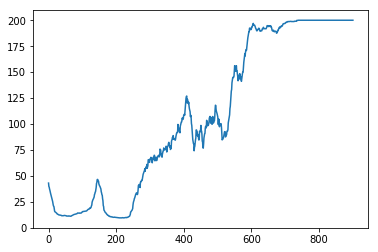

In [31]:
import matplotlib.pyplot as plt
plt.plot(running_mean(episode_callback.episode_rewards,20))
plt.show()

In [ ]:
#SARSA algorithm
def SARSA_algorithm(num_episodes):
    allowed_actions=[0,1]
    # Variables: alpha, gamma y epsilon.
    alpha = 0.3
    gamma = 1
    epsilon = 0.1
    cont = 0
    #Para 5000 episodios de entrenamiento
    for i in range(num_episodes):
        # Inicializa las variables para cada episodio
        state=env.reset()
        num_steps = 0
        state = discretize(state[0])


        # Seleccion accion "a" de forma epsilon-greedy
        if epsilon< np.random.uniform():        
            act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
            action = allowed_actions[np.argmax(act_arg)]
        else:
            action = env.action_space.sample()

        # Inicia el episodio
        continue_episode = True
        while continue_episode:        
            # Obtengo s'
            new_state, reward, done, _,_=env.step(action)
            new_state = discretize(new_state)

            # Revisa que new_state no sea un estado terminal
            if done:
                # Valor q(s',a') terminal
                q_value_next_step = 0
            else:
                #Obtengo a' de s' con epsilon greedy
                if epsilon< np.random.uniform():        
                    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
                    new_action = allowed_actions[np.argmax(act_arg)]
                else:
                    new_action = env.action_space.sample()

                # Valor q(s',a') no terminal
                q_value_next_step = Q_table[tuple(new_state),new_action]


            # Calculo de actualizacion q(s,a) <- q(s,a) + alpha*(R + gamma*q(s',a') - q(s,a))
            Q_table[tuple(state), action] += alpha*(reward + gamma*q_value_next_step - Q_table[tuple(state),action])

            # asigna a = a' y s = s'
            state = new_state
            action = new_action


            # Parte que termina el episodio si se llega a algun estado terminal
            if done:
                continue_episode = False
        cont+=1
        if cont%100==0:
            print(cont)

## SARSA con 400 estados:

In [ ]:
set_states()
set_q_table()

In [ ]:
discrete_values = num_states(400)
SARSA_algorithm(5000)

In [ ]:
allowed_actions= [0,1]
prom=[]
prom_rand=[]
for i in range(100):
    G_pi = 0
    state =env.reset()
    state = state[0]
    state = discretize(state)
    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
    action = allowed_actions[np.argmax(act_arg)]
    done = False
    n=1
    while not done:
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
        discrete_state = discretize(new_state)
        act_arg = np.array([Q_table[tuple(discrete_state), act] for act in range(2)])
        action = allowed_actions[np.argmax(act_arg)]
    prom.append(G_pi)
print('---'*5)
for i in range(100):
    G_pi = 0
    state =env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
    prom_rand.append(G_pi)

In [ ]:
print("Retorno obtenido con la funcion q:",sum(prom)/len(prom))
print("Retorno obtenido de acciones al azar:",sum(prom_rand)/len(prom_rand))

## SARSA con 4000 estados:

In [ ]:
set_states()
set_q_table()

In [ ]:
discrete_values = num_states(4000)
SARSA_algorithm(1000)

In [ ]:
prom=[]
prom_rand=[]
allowed_actions= [0,1]
for i in range(100):
    G_pi = 0
    state =env.reset()
    state = state[0]
    state = discretize(state)
    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
    action = allowed_actions[np.argmax(act_arg)]
    done = False
    n=1
    while not done:
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
        discrete_state = discretize(new_state)
        act_arg = np.array([Q_table[tuple(discrete_state), act] for act in range(2)])
        action = allowed_actions[np.argmax(act_arg)]
    prom.append(G_pi)
print('---'*5)
for i in range(100):
    G_pi = 0
    state =env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
    prom_rand.append(G_pi)

In [ ]:
print("Retorno obtenido con la funcion q:",sum(prom)/len(prom))
print("Retorno obtenido de acciones al azar:",sum(prom_rand)/len(prom_rand))

In [ ]:
env.close()